# Part-1 Data Preprocessing


In [1]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import random

In [2]:
minmaxscaler = MinMaxScaler()

In [3]:
dataset_root_folder = 'C:\\Users\\Admin\\OneDrive\\Desktop\\Satellite Imagery\\data\\satellite\\'

In [4]:
dataset_name = "DubaiDataset"

In [5]:
image_patch_size = 256

In [6]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [8]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000000000002].


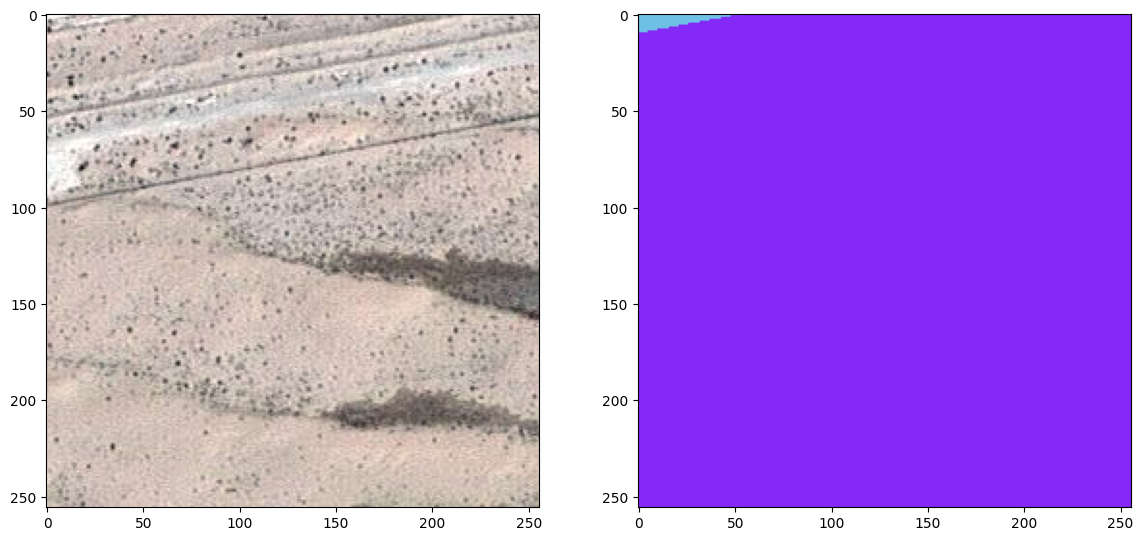

In [9]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [10]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [11]:
label = individual_patched_mask

In [12]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [14]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [15]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [16]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


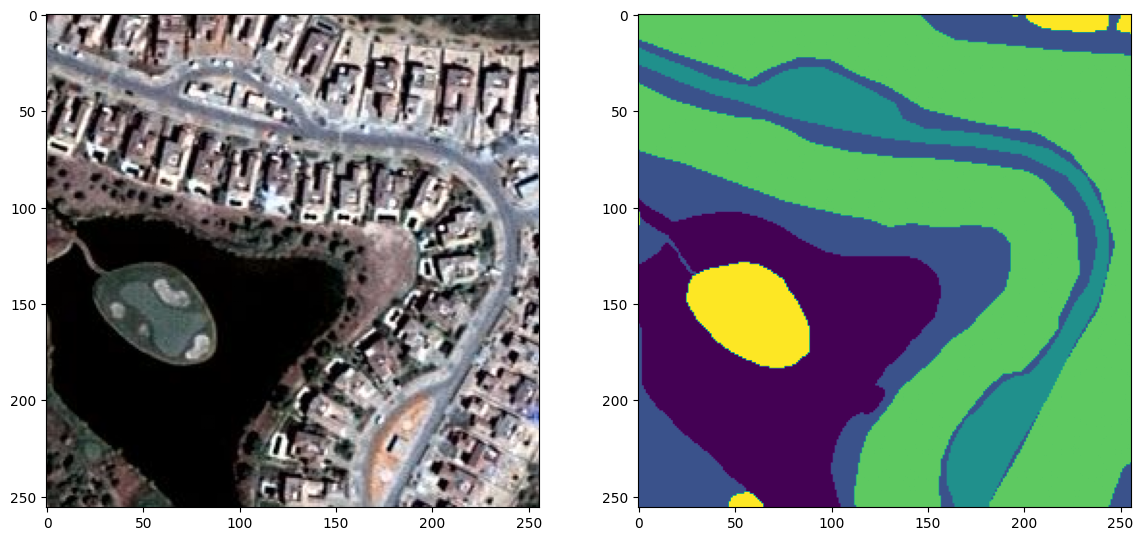

In [17]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [18]:
total_classes = len(np.unique(labels))

In [19]:
total_classes

6

In [20]:
from tensorflow.keras.utils import to_categorical

In [21]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [22]:
master_trianing_dataset = image_dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [25]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [26]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)
     

256
256
3
6


# Part-2 Deep Learning with Satellite Imagery Data

In [27]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K
import tensorflow as tf

In [28]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [29]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [30]:
metrics = ["accuracy", jaccard_coef]

In [31]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [32]:
model = get_deep_learning_model()

In [33]:
model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'cla

# Generating Loss Function

In [34]:

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [35]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [36]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [37]:

focal_loss = sm.losses.CategoricalFocalLoss()

In [38]:
total_loss = dice_loss + (1 * focal_loss)


# Model compilation

In [39]:
import tensorflow as tf

In [40]:
tf.keras.backend.clear_session()

In [41]:
tf.keras.backend.clear_session()

In [42]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

# Visualize Model with Keras


In [44]:
from tensorflow.keras.utils import plot_model
import pydot

In [45]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [46]:
class PlotLoss(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    # self.losses.append(logs.get('loss'))
    # self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1
    
    clear_output(wait=True)
    # plt.plot(self.x, self.losses, label="loss")
    # plt.plot(self.x, self.val_losses, label="val_loss")

    plt.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    plt.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

    plt.legend()
    plt.show();

plot_loss = PlotLoss()

In [47]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)
    
    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

In [48]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

<Figure size 1400x800 with 0 Axes>

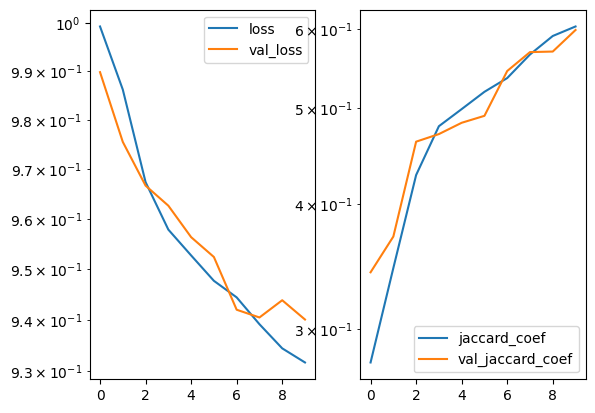

51/51 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.7999 - jaccard_coef: 0.5933 - loss: 0.9337 - val_accuracy: 0.7884 - val_jaccard_coef: 0.5988 - val_loss: 0.9400


In [49]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],
                          shuffle=False)

In [50]:
history_a = model_history

In [51]:
history_a.history

{'accuracy': [0.573515772819519,
  0.6386740803718567,
  0.7067995667457581,
  0.7338438034057617,
  0.7474505305290222,
  0.7621154189109802,
  0.7697584629058838,
  0.7827200889587402,
  0.7951387166976929,
  0.8036131858825684],
 'jaccard_coef': [0.27735888957977295,
  0.3451545238494873,
  0.4280399978160858,
  0.4792712330818176,
  0.49863311648368835,
  0.5189959406852722,
  0.5357853174209595,
  0.565828263759613,
  0.590599000453949,
  0.6037423610687256],
 'loss': [0.9993041157722473,
  0.9862210750579834,
  0.9673513770103455,
  0.9578100442886353,
  0.9526651501655579,
  0.9476263523101807,
  0.9443540573120117,
  0.939081072807312,
  0.934359073638916,
  0.9316080808639526],
 'val_accuracy': [0.6540432572364807,
  0.6879568099975586,
  0.6972214579582214,
  0.7167109251022339,
  0.7375001311302185,
  0.7426570057868958,
  0.7751765847206116,
  0.7808181047439575,
  0.7717661261558533,
  0.7883747816085815],
 'val_jaccard_coef': [0.34175336360931396,
  0.3712310791015625,
  

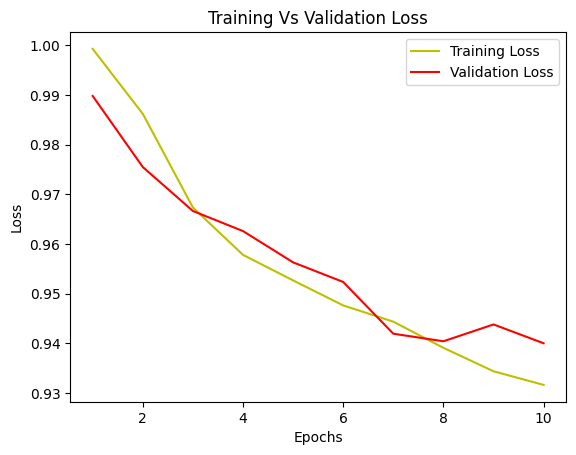

In [52]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

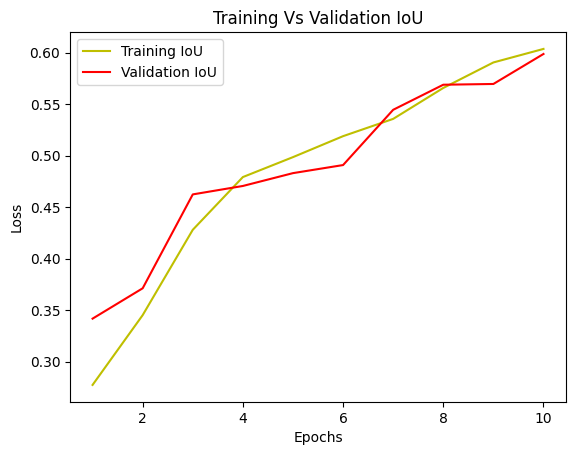

In [53]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [54]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 51}

In [55]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [56]:
len(y_pred)

142

In [57]:
y_pred

array([[[[5.24937697e-02, 4.13875937e-01, 1.85625315e-01,
          1.95613742e-01, 8.66861343e-02, 6.57051206e-02],
         [3.28185782e-02, 5.91040850e-01, 1.61960810e-01,
          1.03687048e-01, 6.34387881e-02, 4.70539778e-02],
         [2.77915187e-02, 6.28666401e-01, 1.53609097e-01,
          8.11148435e-02, 4.82043400e-02, 6.06137253e-02],
         ...,
         [4.59597073e-02, 3.92214626e-01, 1.92816317e-01,
          9.81346518e-02, 2.39959925e-01, 3.09148021e-02],
         [7.02660158e-02, 3.39509040e-01, 1.85389981e-01,
          1.01717055e-01, 2.57853329e-01, 4.52645756e-02],
         [1.31379247e-01, 2.24972665e-01, 2.03360826e-01,
          1.09804496e-01, 2.42208004e-01, 8.82747620e-02]],

        [[2.85926703e-02, 4.28461939e-01, 2.73430467e-01,
          1.47562712e-01, 1.06996588e-01, 1.49556454e-02],
         [2.01027505e-02, 5.66958249e-01, 2.25228027e-01,
          7.04562142e-02, 1.09929398e-01, 7.32536381e-03],
         [1.64202936e-02, 7.05658138e-01, 1.8116

In [58]:
y_test_argmax = np.argmax(y_test, axis=3)

In [59]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# Comparing prediction results

In [60]:
import random

In [61]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]
     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


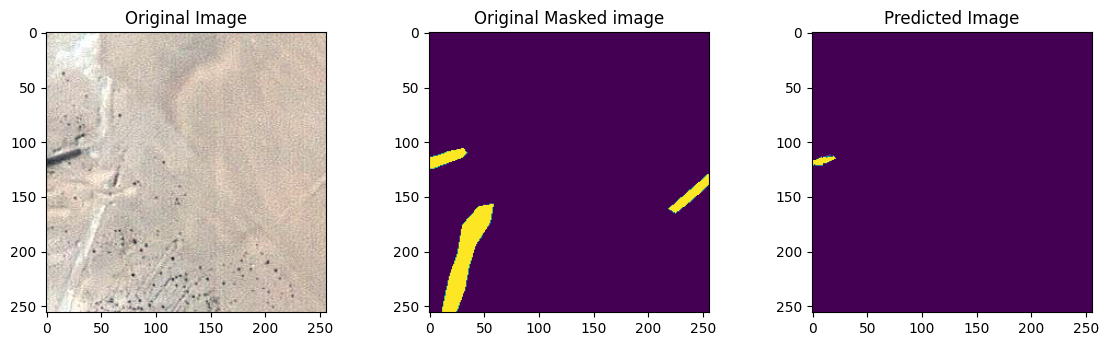

In [62]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [63]:
model.save('satellite-imagery.h5')

In [64]:
#plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)


In [65]:
from keras.models import load_model

In [66]:
saved_model = load_model('C:\\Users\\Admin\\OneDrive\\Desktop\\Satellite Imagery\\satellite-imagery.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 
                                          'jaccard_coef': jaccard_coef}))

In [67]:
model.loss.name

'dice_loss_plus_1focal_loss'

# Performing Prediction using the custom image from Google Map

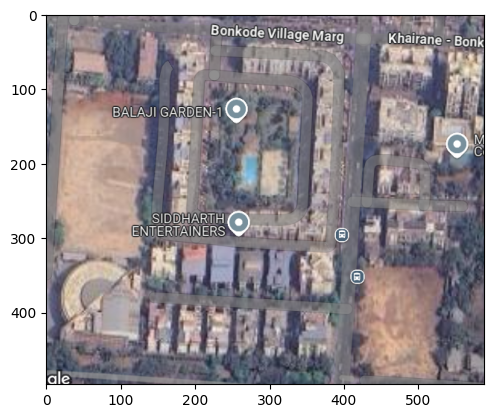

In [68]:
plt.imshow(Image.open('C:\\Users\\Admin\\OneDrive\\Desktop\\Satellite Imagery\\pract\\Screenshot 2024-09-11 035111.png'))

In [69]:
image = Image.open('C:\\Users\\Admin\\OneDrive\\Desktop\\Satellite Imagery\\pract\\Screenshot 2024-09-11 035111.png')
image = image.resize((500,500))
image = np.array(image)
image = np.expand_dims(image, 0)

In [70]:
import cv2
import numpy as np

# Load the image (replace with your actual image loading code)
# Assume 'image' is your input image in RGBA format
image = cv2.imread('C:\\Users\\Admin\\OneDrive\\Desktop\\Satellite Imagery\\pract\\Screenshot 2024-09-11 035111.png', cv2.IMREAD_UNCHANGED)  # Load with all channels including alpha

# Check if the image has 4 channels (RGBA) and convert to RGB
if image.shape[-1] == 4:
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

# Ensure the image shape matches the expected input shape of the model
image = cv2.resize(image, (256, 256))
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Predict using the model
prediction = saved_model.predict(image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


In [71]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]
     

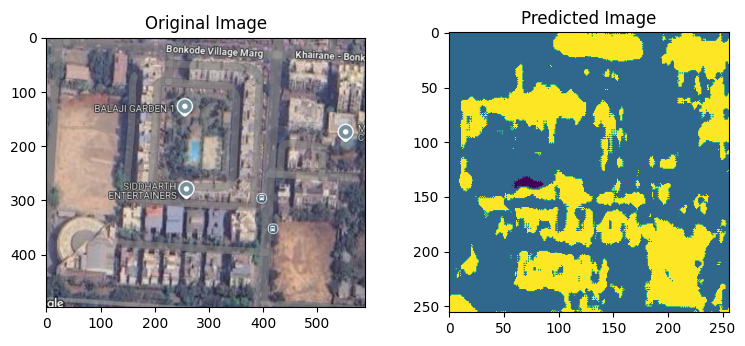

In [72]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('C:\\Users\\Admin\\OneDrive\\Desktop\\Satellite Imagery\\pract\\Screenshot 2024-09-11 035111.png'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

# Gradio UI


In [76]:
import gradio as gr
import numpy as np
from PIL import Image

def process_input_image(image_source):
    # Convert the input image to a NumPy array
    image = np.array(image_source)
    
    # Resize the image to the expected size (256*256)
    image_resized = np.array(Image.fromarray(image).resize((256,256)))
    
    image_resized = np.expand_dims(image_resized, 0)
    
    # Ensure `saved_model` is defined and loaded
    prediction = saved_model.predict(image_resized)
    predicted_image = np.argmax(prediction, axis=3)
    
    predicted_image = predicted_image[0, :, :]
    predicted_image = predicted_image * 50  # Adjust scaling as needed
    
    return 'Predicted Masked Image', predicted_image

my_app = gr.Blocks()

with my_app:
    gr.Markdown("Satellite Image Segmentation Application UI with Gradio")
    with gr.Tabs():
        with gr.TabItem("Select your image"):
            with gr.Row():
                with gr.Column():
                    img_source = gr.Image(label="Please select source Image")
                    source_image_loader = gr.Button("Load above Image")
                with gr.Column():
                    output_label = gr.Textbox(label="Image Info", lines=1)
                    img_output = gr.Image(label="Image Output")

    source_image_loader.click(
        process_input_image,
        inputs=[img_source],
        outputs=[output_label, img_output]
    )

my_app.launch(share=True)


Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://b483b2b2a6a83a0328.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [77]:
#my_app.close()


Closing server running on port: 7862
